In [1]:
# Shelterluv Adoption & Length of Stay Analysis
# ---------------------------------------------
# Basic setup: load libraries and configure visuals

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Make plots look nice
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Show all columns in pandas output
pd.set_option("display.max_columns", None)

In [3]:
# Load Data

## Load demographic data
df_demo = pd.read_csv("../data/SL_data_20251112.csv")

## Load length-of-stay/outcome data
df_los = pd.read_csv("../data/SL_length_of_stay_20251112.csv")

## Merge datasets on 'Animal ID'
df = pd.merge(df_demo, df_los, on='Animal ID', how='inner')

## Quick peak at data to get column names
df.head()

,Date Created,Intake Date_x,Animal ID,Name,Primary Breed_x,Secondary Breed_x,Sex,Age (Y/M/D),Age Group,Birthdate,Primary Color,Secondary Color,Pattern,Microchip Number,Microchip Issuer,Microchip Implant Date,Adoption Category,Current Location_x,Days In Custody,Current Status_x,Holdable,Adoptable,In Custody,Adoption Fee Group,Foster Person ID,Foster Person Name,Photo,Foster Notes,Animal Name,Species,Primary Breed_y,Secondary Breed_y,Date of Birth,Age Group at Intake,Current Status_y,Current Location_y,Intake Date_y,Intake Type,Outcome Date,Outcome Type,Days in Custody,Days Onsite,Days Available
0,06/20/2024,04/18/2024,CCL-A-1,Alice,Domestic Shorthair,—,Female,11Y/6M/26D,Senior Cat,4/16/2014,Torbie,NaN,NaN,NaN,—,—,—,Euthanased,88,Deceased,No,No,No,—,—,—,https://new-s3.shelterluv.com/profile-pictures...,—,Alice,Cat,Domestic Shorthair,NaN,4/16/2014,Senior Cat (8+ years),Deceased,Euthanased,4/18/2024,Stray In,7/14/2024,Euthanasia,88,88,88
1,06/26/2024,03/18/2024,CCL-A-2,Asher,Domestic Shorthair,—,Male,2Y/8M/0D,Adult Cat,3/12/2023,Black,NaN,NaN,992000003360734,NanoCHIP,—,Restrictions,Adopted: Sandra Decker,212,Healthy In Home,No,No,No,Bonded Pair,—,—,https://new-s3.shelterluv.com/profile-pictures...,—,Asher,Cat,Domestic Shorthair,NaN,3/12/2023,Adult Cat (5 months-8 years),Healthy In Home,Adopted: Sandra Decker,3/18/2024,Stray In,10/15/2024,Adoption,212,212,212
2,06/26/2024,06/03/2024,CCL-A-4,Criminal,Domestic Shorthair,—,Male,2Y/11M/27D,Adult Cat,11/15/2022,Orange,NaN,NaN,992000003226634,Other,—,—,Adopted: Shyanne Baker,108,Healthy In Home,No,No,No,Adult Cat,—,—,https://new-s3.shelterluv.com/profile-pictures...,—,Criminal,Cat,Domestic Shorthair,NaN,11/15/2022,Adult Cat (5 months-8 years),Healthy In Home,Adopted: Shyanne Baker,6/3/2024,Stray In,9/18/2024,Adoption,108,108,108
3,06/26/2024,04/04/2024,CCL-A-5,Cedar,Domestic Shorthair,—,Female,2Y/5M/8D,Adult Cat,6/4/2023,Brown,NaN,Tabby,992000003226633,NanoCHIP,—,Medical Special Adoption,Adopted: Linay Verge,185,Healthy In Home,No,No,No,FIV+,—,—,https://new-s3.shelterluv.com/profile-pictures...,—,Cedar,Cat,Domestic Shorthair,NaN,6/4/2023,Adult Cat (5 months-8 years),Healthy In Home,Adopted: Linay Verge,4/4/2024,Stray In,10/5/2024,Adoption,185,185,185
4,06/26/2024,06/10/2024,CCL-A-6,Brittle (Max),Domestic Shorthair,—,Female,3Y/7M/10D,Adult Cat,4/2/2022,Calico,NaN,NaN,99200003226732,Other,—,—,Adopted: Jakyrah Harris,101,Healthy In Home,No,No,No,Adult Cat,—,—,https://new-s3.shelterluv.com/profile-pictures...,—,Brittle (Max),Cat,Domestic Shorthair,NaN,4/2/2022,Adult Cat (5 months-8 years),Healthy In Home,Adopted: Jakyrah Harris,6/10/2024,Stray In,9/18/2024,Adoption,101,101,101


In [8]:
# Clean and Prepare Data

## Check column types, is possibly a string at this point
print(df[['Intake Date_x','Outcome Date']].dtypes)
      
## Convert date columns to datetime
df['Intake Date'] = pd.to_datetime(df['Intake Date_x'], errors='coerce')
df['Outcome Date'] = pd.to_datetime(df['Outcome Date'], errors='coerce')

## Check column types, should be a datetime
print(df[['Intake Date','Outcome Date']].dtypes)

## Calculate Length of Stay
df['Length of Stay (days)'] = (df['Outcome Date'] - df['Intake Date']).dt.days

## Define a function to extract the name
def extract_foster(text):
    if pd.isna(text):
        return None
    # Try multiple common patterns
    patterns = [
        r'Foster Name:[: ]+([A-Za-z ]+)',
        r'Fostered by[: ]+([A-Za-z ]+)',
        r'Foster:[: ]+([A-Za-z ]+)',
        r'([A-Z][a-z]+ [A-Z][a-z]+) is the foster',
        r'\b(Tammy Miller|Jourdan Parenteau|Amy Jackson|Autumn Jackson|Kat Trimmer|Katie Tucker|Joanne CarolNatascha Fuller|Suzy Pruitt)\b'
    ]
    for pat in patterns:
        match = re.search(pat, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return None

df['Foster Name'] = df['Foster Notes'].apply(extract_foster)

## Remove rows with missing critical data
df = df.dropna(subset=['Intake Date', 'Outcome Date', 'Length of Stay (days)', 'Foster Name'])

## Remove negative LOS
df = df[df['Length of Stay (days)'] >= 0]

## Take a peak
df[['Animal ID', 'Intake Date', 'Outcome Date', 'Primary Breed_x', 'Sex', 'Age Group', 'Primary Color', 'Adoption Fee Group', 'Outcome Type', 'Foster Name']].head()


Intake Date_x            object
Outcome Date     datetime64[ns]
dtype: object
Intake Date     datetime64[ns]
Outcome Date    datetime64[ns]
dtype: object


,Animal ID,Intake Date,Outcome Date,Primary Breed_x,Sex,Age Group,Primary Color,Adoption Fee Group,Outcome Type,Foster Name
209,CCL-A-223,2024-09-20,2024-12-26,Domestic Shorthair,Female,Adult Cat,Grey,Adult Cat,Adoption,Tammy Miller
325,CCL-A-8069,2024-12-04,2025-01-12,Domestic Shorthair,Female,Adult Cat,Grey,Adult Cat,Adoption,Katie Tucker
326,CCL-A-8070,2024-12-04,2025-01-07,Domestic Shorthair,Male,Adult Cat,Black,Adult Cat,Adoption,Katie Tucker
327,CCL-A-8071,2024-12-04,2025-01-08,Domestic Shorthair,Female,Adult Cat,Grey,Adult Cat,Adoption,Katie Tucker
328,CCL-A-8072,2024-12-04,2025-01-15,Domestic Shorthair,Female,Adult Cat,Grey,Kitten,Adoption,Kat Trimmer


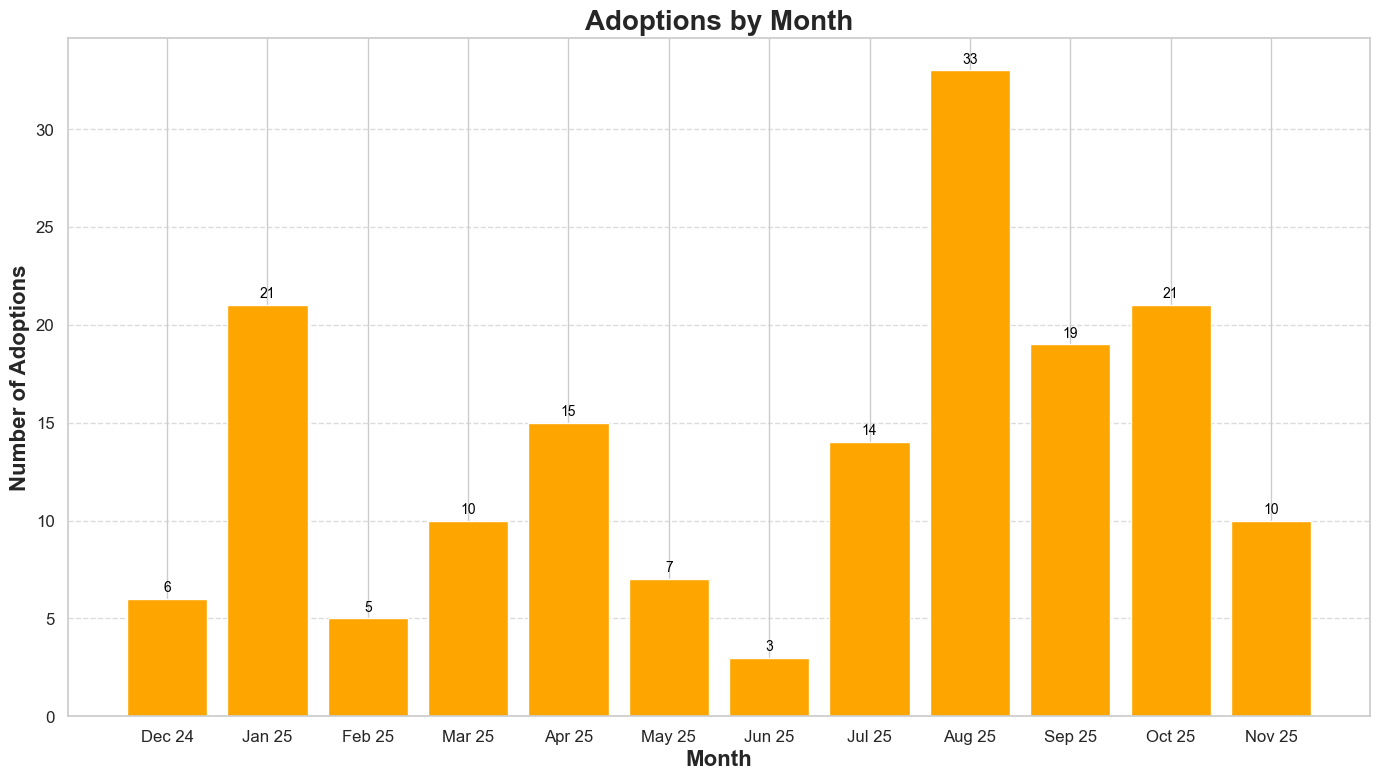

In [9]:
# Adoptions Over Time Analysis
## Filter to adoption outcomes
adoptions = df[df['Outcome Type'].str.lower().str.contains('adoption', na=False)]

## Group by month
adoptions_over_time = (
    adoptions.groupby(adoptions['Outcome Date'].dt.to_period('M'))
    .size()
    .rename("Adoptions")
    .reset_index()
)

## Convert 'Outcome Date' from Period to datetime, then format as MM/YY
adoptions_over_time['Outcome Date'] = (
    adoptions_over_time['Outcome Date']
    .dt.to_timestamp()
    .dt.strftime('%b %y')
)

## Create bar chart
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(adoptions_over_time['Outcome Date'], adoptions_over_time['Adoptions'], color='orange')

## Titles and labels
ax.set_title("Adoptions by Month", fontsize=20, fontweight='bold')
ax.set_xlabel("Month", fontsize=16, fontweight='bold')
ax.set_ylabel("Number of Adoptions", fontsize=16, fontweight='bold')
ax.bar_label(ax.containers[0], padding=3, color='black', fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


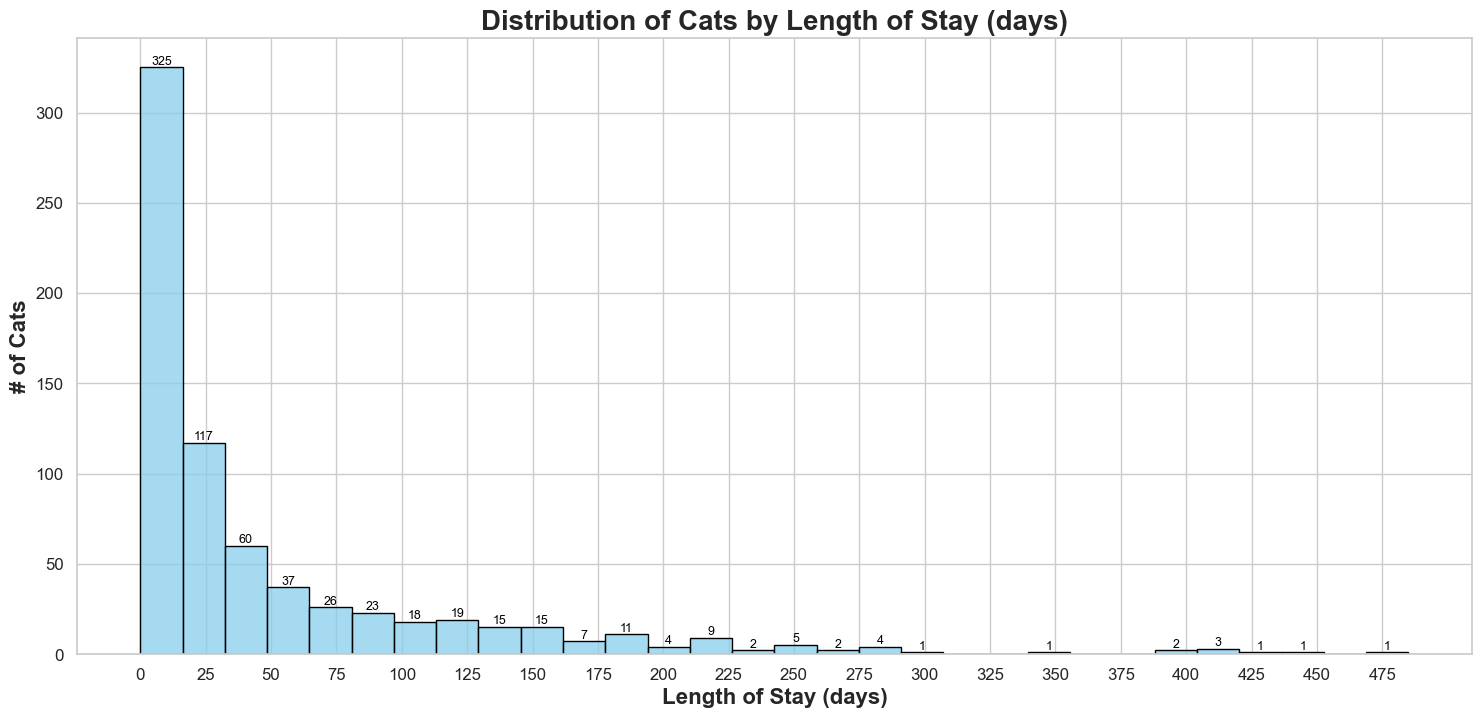

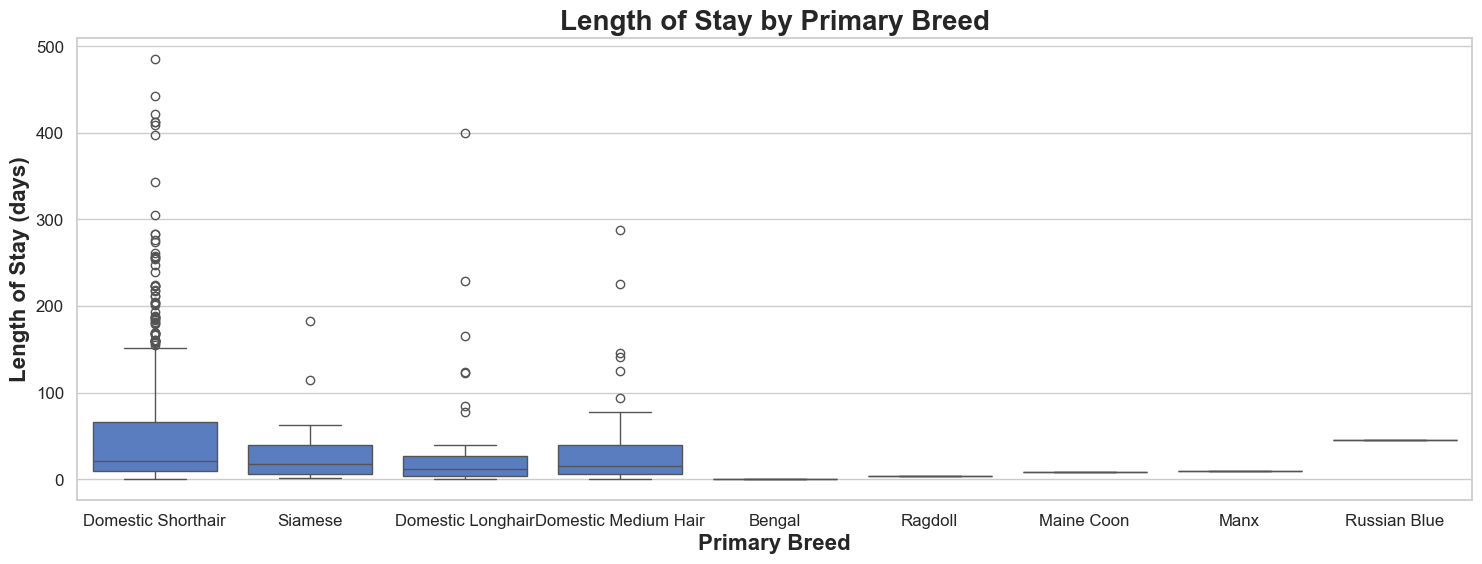

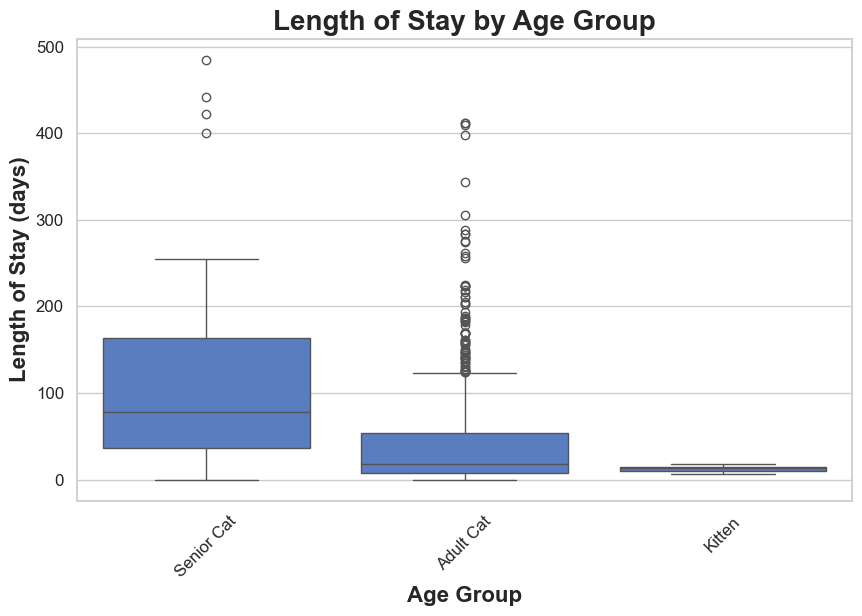

In [25]:
# Length of Stay Analysis

## Histogram of Length of Stay
plt.figure(figsize=(18,8))
ax = sns.histplot(df['Length of Stay (days)'], bins=30, kde=False, color='skyblue', edgecolor='black')

## Add labels above bars
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width()/2,  # center of the bar
            height,
            int(height),                          # label
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

## Set x-axis ticks
max_days = int(df['Length of Stay (days)'].max())
ticks = np.arange(0, max_days + 1, 25)
ax.set_xticks(ticks)

## Titles and labels
plt.title("Distribution of Cats by Length of Stay (days)", fontsize=20, fontweight='bold')
plt.xlabel("Length of Stay (days)", fontsize=16, fontweight='bold')
plt.ylabel("# of Cats", fontsize=16, fontweight='bold')
plt.show()

## Boxplot by Primary Breed
if 'Primary Breed_x' in df.columns:
    plt.figure(figsize=(18,6))
    sns.boxplot(data=df, x='Primary Breed_x', y='Length of Stay (days)')
    plt.title("Length of Stay by Primary Breed", fontsize=20, fontweight='bold')
    plt.xlabel("Primary Breed", fontsize=16, fontweight='bold')
    plt.ylabel("Length of Stay (days)", fontsize=16, fontweight='bold')
    plt.show()

## Boxplot by Age Group
if 'Age Group' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='Age Group', y='Length of Stay (days)')
    plt.title("Length of Stay by Age Group", fontsize=20, fontweight='bold')
    plt.xlabel("Age Group", fontsize=16, fontweight='bold')
    plt.ylabel("Length of Stay (days)", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.show()

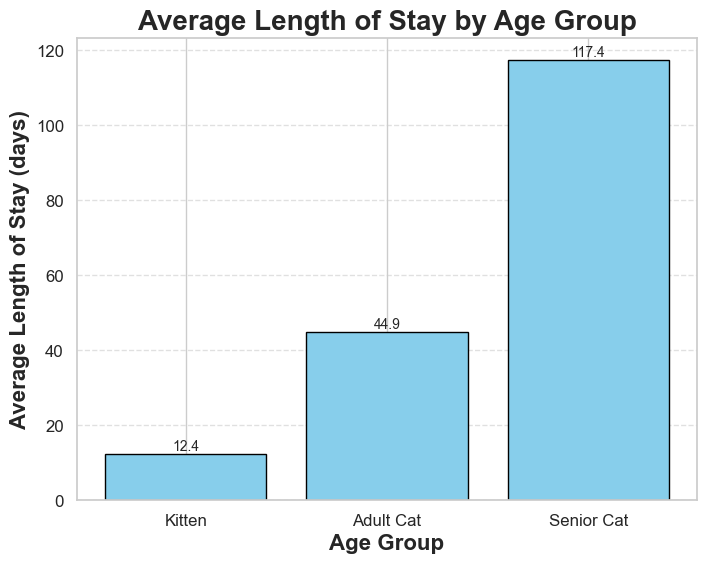

In [39]:
# Average Length of Stay (days) by Age Group

## Calculate average Length of Stay by Age Group
avg_los = df.groupby('Age Group')['Length of Stay (days)'].mean().reset_index()

## Define a logical age order
age_order = ['Kitten', 'Adult Cat', 'Senior Cat']
avg_los['Age Group'] = pd.Categorical(avg_los['Age Group'], categories=age_order, ordered=True)
avg_los = avg_los.sort_values('Age Group')

## Create bar chart
plt.figure(figsize=(8,6))
bars = plt.bar(avg_los['Age Group'], avg_los['Length of Stay (days)'], color='skyblue', edgecolor='black')

## Add numeric labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.1f}",
             ha='center', va='bottom', fontsize=10)

## Titles and labels
plt.title("Average Length of Stay by Age Group", fontsize=20, fontweight='bold')
plt.xlabel("Age Group", fontsize=16, fontweight='bold')
plt.ylabel("Average Length of Stay (days)", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Mean Absolute Error (MAE): 49.68 days
R^2 Score: 0.11


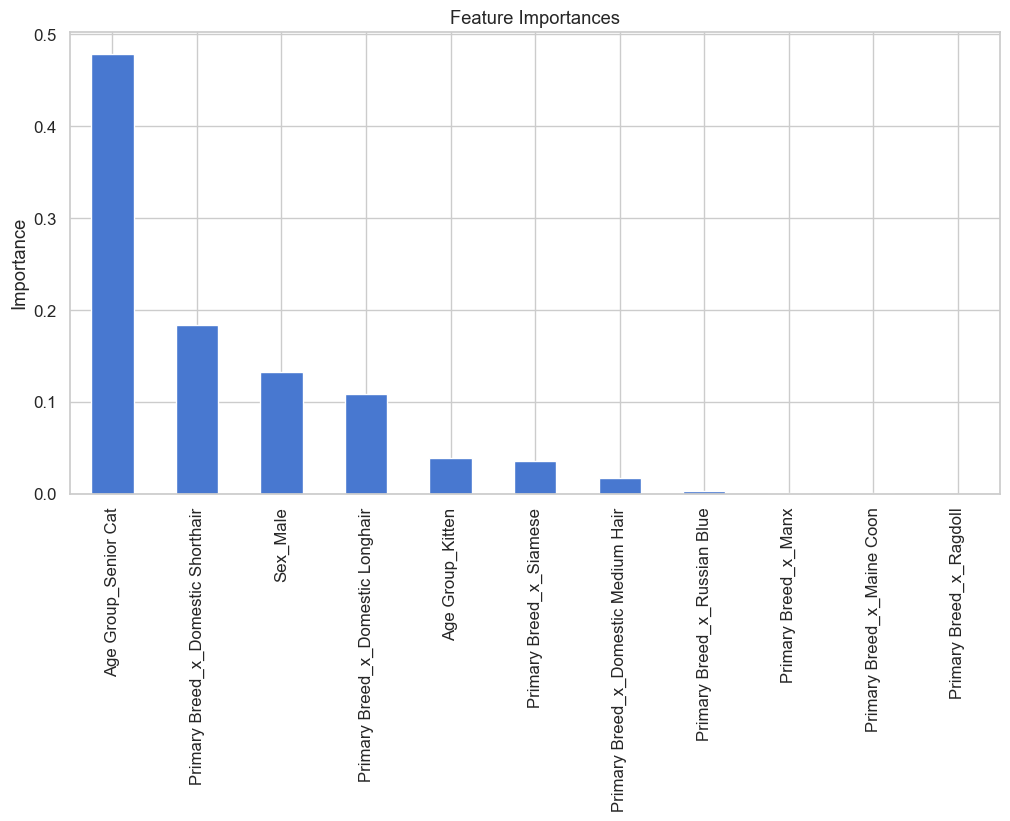

In [41]:
# Predictive Model for Length of Stay

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## Features for prediction
features = ['Age Group', 'Sex', 'Primary Breed_x',]
df_model = df[features + ['Length of Stay (days)']].dropna()

## One-hot encode categorical variables
df_model = pd.get_dummies(df_model, drop_first=True)

## Split features and target
X = df_model.drop('Length of Stay (days)', axis=1)
y = df_model['Length of Stay (days)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

## Make predictions
y_pred = model.predict(X_test)

## Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"The MAE measures, on average, how far the model’s predictions are from the actual observed values.")
print(f"R² Score: {r2:.2f}")
print(f"R² captures what fraction of the variance in the target is captured by the model. When the model explains most 
of the variation, the R² will be close to 1. If the model just predicted the mean length of stay for everything, R² would be 0.")

## Feature importance
print(f"Feature importance tells you which variables in the dataset have the biggest impact on the model’s predictions. 
In this case, it measures how much each variable influences how long a cat stays in the shelter. The Random Forest model calculates 
feature importance by how much each feature reduces prediction error (or “impurity”) across all the decision trees.
Larger values = feature contributes more to improving accuracy.")
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(12,6), title="Feature Importances")
plt.ylabel("Importance")
plt.show()
